# STA 561 HW 7/8 {-}

Authors  
 -  Alonso Guerrero Castaneda (UID: 1194613)  
 -  Eli Gnesin (UID: 1172961)  
 -  Tommy Misikoff (UID: 1166813)  
 -  Sanskriti Purohit (UID: 1179957)  
 -  Will Tirone (UID: 1130904)  

TA: Rick Presman 

In [1]:
#Import Lines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import ConvexHull

## Homework 7: Question 1 {-}

What is the optimal decision rule $\pi$?

We can base our decision rule $\pi$ on the same conditions as A, i.e. assign the decision 0 when $|X|>\tau$ and 1 when $|X|\leq\tau$. Further, we can find the optimum $\tau$ for which the value $V(\pi)$ is maximized. For this question, we explore $\tau = 0.01$ and $\tau = 0.025$ by simulation.

The proportion of significant betas at alpha = 0.05 with tau = 0.01 was 0.052
The proportion of significant betas at alpha = 0.05 with tau = 0.025 was 0.056


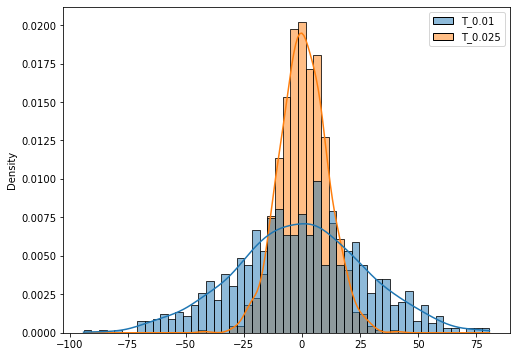

In [2]:
#Simulation with tau = 0.01 and tau = 0.025
n = 500
B = 1000
b0 = b1 = b2 = 1
b3 = 0.5
tau = [0.01, 0.025]
p_values = [[],[]]

#Dataframes of betas for storage
betas0 = pd.DataFrame(columns = ["T_0.01", "T_0.025"])
betas1 = pd.DataFrame(columns = ["T_0.01", "T_0.025"])
betas2 = pd.DataFrame(columns = ["T_0.01", "T_0.025"])
betas3 = pd.DataFrame(columns = ["T_0.01", "T_0.025"])

#Create our random number generator
rng = np.random.default_rng(seed = 0)

for b in range(B):
    #Create our X
    samp = rng.normal(loc = 0, scale = 1, size = n)
    X = np.power(samp, 5) #If X^{1/5} is N(0,1), then X is N(0,1)^5
    #print(X)

    for t in tau:
        #Create A
        A = [1 if np.abs(x) <= t else 0 for x in X]
        #print(A)

        #Create Y
        err = rng.normal(loc = 0, scale = 1, size = n)
        Y = (b0 * np.ones(n)) + (b1 * A) + (b2 * X) + (b3 * (A * X)) + err
        #print(Y)

        #Build a dataframe
        df = pd.DataFrame(list(zip(X, A, Y)))
        df.columns = ["X", "A", "Y"]

        #Now the OLS
        mod = sm.OLS.from_formula("Y ~ A + X + A*X", data = df)
        res = mod.fit()
        
        #Storing the values
        if t == 0.01:
            p_values[0].append(res.pvalues[3])
            bt0 = res.params[0]
            bt1 = res.params[1]
            bt2 = res.params[2]
            bt3 = res.params[3]
        else:
            p_values[1].append(res.pvalues[3])
            betas0.loc[len(betas0)] = [bt0, res.params[0]]
            betas1.loc[len(betas1)] = [bt1, res.params[1]]
            betas2.loc[len(betas2)] = [bt2, res.params[2]]
            betas3.loc[len(betas3)] = [bt3, res.params[3]]

print(f"The proportion of significant betas at alpha = 0.05 with tau = 0.01 was {np.mean([1 if x < 0.05 else 0 for x in p_values[0]])}")
print(f"The proportion of significant betas at alpha = 0.05 with tau = 0.025 was {np.mean([1 if x < 0.05 else 0 for x in p_values[1]])}")

plt.figure(figsize = (8,6))
sns.histplot(data = betas3, stat = "density", kde = True)
plt.show()

In [3]:
#Print the mean and standard deviation for each beta under each tau

print("Beta 3:")
print(betas3.mean())
print(betas3.std(axis = 0))
print()
print("Beta 2:")
print(betas2.mean())
print(betas2.std(axis = 0))
print()
print("Beta 1:")
print(betas1.mean())
print(betas1.std(axis = 0))
print()
print("Beta 0:")
print(betas0.mean())
print(betas0.std(axis = 0))
print()

Beta 3:
T_0.01    -1.058091
T_0.025    0.610253
dtype: float64
T_0.01     27.792196
T_0.025    10.314448
dtype: float64

Beta 2:
T_0.01     0.999921
T_0.025    1.000097
dtype: float64
T_0.01     0.001843
T_0.025    0.001867
dtype: float64

Beta 1:
T_0.01     1.003534
T_0.025    0.993367
dtype: float64
T_0.01     0.095065
T_0.025    0.095357
dtype: float64

Beta 0:
T_0.01     0.997749
T_0.025    1.004621
dtype: float64
T_0.01     0.053929
T_0.025    0.057699
dtype: float64



Looking at the results of the simulation above, at a level of $\alpha = 0.05$, the proportion of significant $\beta_3$ for $\tau = 0.01$ is 5.2% and the proportion of significant $\beta_3$ for $\tau = 0.025$ is 5.6% (meaning if we were to conduct a hypothesis where $H_0: \beta_3 = 0.5$ and $H_1: \beta_3 \neq 0.5$, we would fail to reject the null hypothesis at $\alpha = 0.05$ by the slimmest of margins). Looking at a histogram of $\beta_3$, further, shows that $\beta_3$ is highly dispersed. From the summary statistics, while $\beta_0, \beta_1, \beta_2$ all are very tightly distributed around their true means of 1, with standard deviations less than 0.1, so it is fair to say that $\hat{\beta_0}, \hat{\beta_1}, \hat{\beta_2}$ are relatively good estimators of $\beta_0, \beta_1, \beta_2$, it appears that the same does not hold true for $\beta_3$, which has a standard deviation of 27 for $\tau = 0.01$ and 10 for $\tau = 0.025$. From this, we can see that the OLS model is unstable, at least in its assessment of $\beta_3$.

From this, it appears that at least one of the standard causal assumptions are being violated here. With the assumption of *positivity*, let $\epsilon > 0$ be fixed. Then suppose we have $x \in \mathbb{X}$. Clearly, if $|x| \leq \tau$, then $A = 1$ and $P(A = 0 | X = x) = 0 < \epsilon$, and likewise if $|x| > \tau$, then $A = 0$ and $P(A = 1| X = x) = 0 < \epsilon$. Regardless, of what $x \in \mathbb{X}$ actually is, then, we have $P(A = a|X = x) = 0 < \epsilon$ for one of $A \in \{0,1\}$, and the assumption of positivity is violated. Concretely, the issue is that we define $A$ to be an indicator variable based on X, in such a way that there is zero overlap between the treatment groups $A = 0$ and $A = 1$, and so an individual has no possibility of being assigned to either group. For contrast, below we consider the same exact setup, except this time, we flip a coin with 95% probability of being a 1 if $|X| \leq \tau$ and we flip a coin with 5% probability of being a 1 if $|X| > \tau$, and thus we allow minimal overlap between groups. In this case, with even a very minimal overlap, $\beta_3$ is distributed tightly around its true value of $0.05$ and over 99% of the values of $\beta_3$ have a significant p-value at $\alpha = 0.05$. From this, we can see that the violation of the positivity assumption is a root cause of the high variance in estimating $\beta_3$ above.

We now consider the other two standard assumptions. First, with *consistency*, we have no interaction going on between $X$ draws with respect to an individal $Y$, and so $Y$ is the potential outcome $Y^*(A)$ under action $A$, which is uniquely determined only by the single $X$ draw, and therefore we have consistency. Similarly, for the assumption of *no unmeasured confounders*, since we know $A$ concretely given $X$ (and each draw of $X$ is independent from every other draw of $X$), having $X$ contains all the necessary information for determining $A$, and consequently for determining $Y$, so there are no unmeasured counfounders that need to be accounted for. Thus, the other two standard causal assumptions are not violated, and it is the violation of the *positivity* assumption that is causing the instability in the estimation of $\hat{\beta_3}$.

The proportion of significant betas at alpha = 0.05 with tau = 0.01 was 0.995
The proportion of significant betas at alpha = 0.05 with tau = 0.025 was 0.996
Beta 3:
T_0.01     0.499411
T_0.025    0.501900
dtype: float64
T_0.01     0.055642
T_0.025    0.039848
dtype: float64


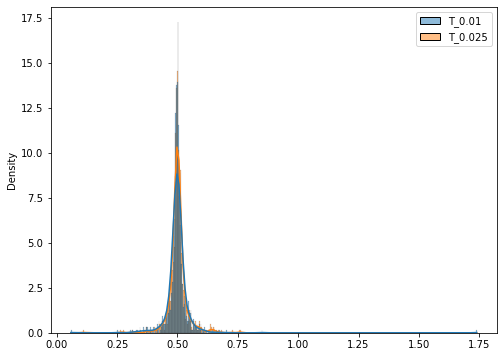

In [4]:
p_values = [[],[]]
betas3 = pd.DataFrame(columns = ["T_0.01", "T_0.025"])

#Create our random number generator
rng = np.random.default_rng(seed = 0)

for b in range(B):
    # Create our X
    samp = rng.normal(loc = 0, scale = 1, size = n)
    X = np.power(samp, 5) #If X^{1/5} is N(0,1), then X is N(0,1)^5
    #print(X)

    for t in tau:
        #Create A
        A = [rng.binomial(1, 0.95) if np.abs(x) <= t else rng.binomial(1, 0.05) for x in X]
        #print(A)

        #Create Y
        err = rng.normal(loc = 0, scale = 1, size = n)
        Y = (b0 * np.ones(n)) + (b1 * A) + (b2 * X) + (b3 * (A * X)) + err
        #print(Y)

        #Build a dataframe
        df = pd.DataFrame(list(zip(X, A, Y)))
        df.columns = ["X", "A", "Y"]

        #Now the OLS
        mod = sm.OLS.from_formula("Y ~ A + X + A*X", data = df)
        res = mod.fit()
        #print(res.pvalues[3]) #This is the p-value for beta_3
        if t == 0.01:
            p_values[0].append(res.pvalues[3])
            bt3 = res.params[3]
        else:
            p_values[1].append(res.pvalues[3])
            betas3.loc[len(betas3)] = [bt3, res.params[3]]

print(f"The proportion of significant betas at alpha = 0.05 with tau = 0.01 was {np.mean([1 if x < 0.05 else 0 for x in p_values[0]])}")
print(f"The proportion of significant betas at alpha = 0.05 with tau = 0.025 was {np.mean([1 if x < 0.05 else 0 for x in p_values[1]])}")

print("Beta 3:")
print(betas3.mean())
print(betas3.std(axis = 0))

plt.figure(figsize = (8,6))
sns.histplot(data = betas3, stat = "density", kde = True)
plt.show()

## Homework 8: Question 2 {-}

We are choosing not to do this question and to let Homework 8 be one of our dropped homeworks.